### The overall processing pipeline
Start with desc-restor version of image
MAKE SURE TO RETABULATE RADIOLOGY LEVEL USING SESSIONS.TSV FILE

Reference image will be from subject sub-CC00058XX09 as before

Make sure to keep preprocessed images separate from each other instead of one mega matrix :)

- Skull stripping (originally using bet2 w/ -f 0.2, but maybe we can just use the brain masks supplied with the data)
    - Note: it appears that the brain mask from dhcp pipeline is good, so let's use it CONFIRMED
- n3_bias_field_correction
- resample image to 256x256x256
- register to ref image using AffineFast method
- histogram matching to uniform distribution
- standardize (0 to 1) each image TO ITSELF

Needs:
- Register segmentation map while we're at it
- Preserve transform matrix to ensure original data can be represented (this doesn't appear to work, ignore for now)

### Import Libraries

In [1]:
import nibabel
import ants
import numpy as np
import pandas as pd
import os
from math import ceil
import multiprocessing as mp
import re
import matplotlib.pyplot as plt
import glob

from nilearn.image import load_img, smooth_img, resample_img, get_data
from nilearn.plotting import show, view_img, plot_img

### Define Paths

In [2]:
data_dir = "/code/data/dhcp_rel2"
og_dir = os.path.join(data_dir, "original_samples")
og_volumes = os.path.join(og_dir, "volumes")
og_segments = os.path.join(og_dir, "segments")
processed_dir = os.path.join(data_dir, "processed")
processed_volumes = os.path.join(processed_dir, "volumes")
processed_segments = os.path.join(processed_dir, "segments")

### Define Histogram Normalization

In [3]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image.
    Code adapted from
    http://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
#     s_quantiles /= s_quantiles[-1]
    s_min = min(s_quantiles)
    s_max = max(s_quantiles)
    s_quantiles = (s_quantiles - s_min) / (s_max - s_min)
    
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

np.random.seed(42)
uniform = np.random.uniform(size=500)

### Helper Functions

In [4]:
def process_image(img, mask, dims, ref, ud, skip_bias=False, skip_reg=False, skip_norm=False):
    """Processes image for modeling.
    
    inputs:
        - image to process
        - brain mask
        - xyz dims to process to (tuple)
        - ref image for registration
        - uniform distribution for normalization
    outputs:
        - processed image
    """

    processed_img = ants.mask_image(img, mask)
    if not skip_bias:
        processed_img = ants.n3_bias_field_correction(processed_img)
    processed_img = ants.resample_image(processed_img, dims, True, 1)
    
    if not skip_reg:
        processed_img = ants.registration(fixed=ref, moving=processed_img, type_of_transform='AffineFast')['warpedmovout']
    
    if not skip_norm:        
        # norming
        # processed_img = hist_match(processed_img.numpy(), ud)
        processed_img = processed_img.numpy()
        
        # standardize
        amax = np.amax(processed_img)
        amin = np.amin(processed_img)
        processed_img = (processed_img - amin) / (amax - amin)
    
    return processed_img

### Process Data

In [5]:
%%time
dims = (256, 256, 256)

# generate reference image
# ref_path = os.path.join(og_volumes, "l1", "sub-CC00062XX05_13801_T2w.nii.gz")
# ref_mask_path = os.path.join(og_segments, "l1", "sub-CC00062XX05_13801_bet_mask.nii.gz")
ref_dir = os.path.join(data_dir, "ref")
ref_path = os.path.join(ref_dir, "sub-CC00058XX09_ses-11300_desc-restore_T2w.nii.gz")
ref_mask_path = os.path.join(ref_dir, "sub-CC00058XX09_ses-11300_desc-bet_space-T2w_brainmask.nii.gz")
ref_img = ants.image_read(ref_path)
ref_mask = ants.image_read(ref_mask_path)

processed_ref = process_image(ref_img, ref_mask, dims, ref_img, uniform, skip_reg=True, skip_norm=True)

CPU times: user 17.9 s, sys: 1.31 s, total: 19.2 s
Wall time: 3.82 s


### Aside for SEG

In [8]:
t1 = ants.image_read(t1_path)
t2 = ants.image_read(t2_path)
seg = ants.image_read(seg_path)
mask = ants.image_read(mask_path) 

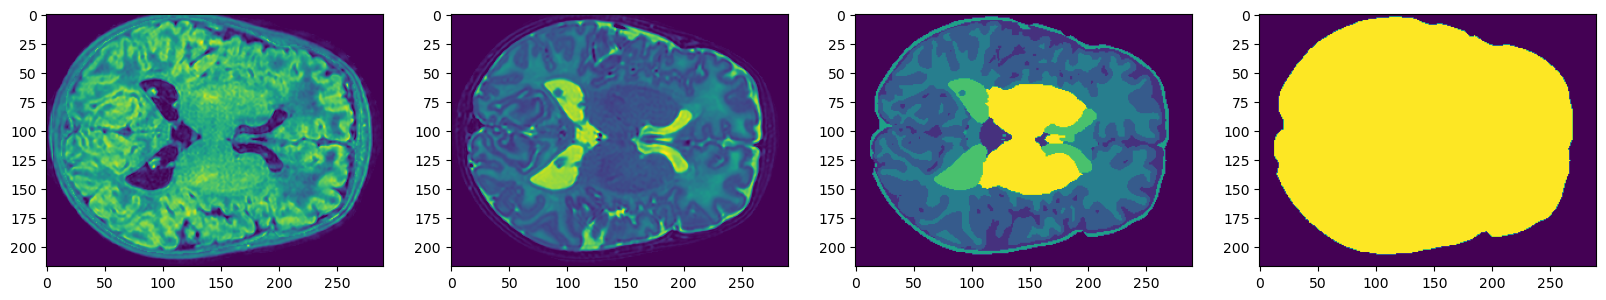

In [10]:
ms = 145
fig, ax = plt.subplots(1, 4, figsize=(20,20))
ax[0].imshow(t1.numpy()[:,:,ms])
ax[1].imshow(t2.numpy()[:,:,ms])
ax[2].imshow(seg.numpy()[:,:,ms])
ax[3].imshow(mask.numpy()[:,:,ms])

In [11]:
processed_img = ants.mask_image(t2, mask)
processed_img = ants.n3_bias_field_correction(processed_img)
processed_img = ants.resample_image(processed_img, dims, True, 1)
processed_img = ants.registration(fixed=processed_ref, moving=processed_img, type_of_transform='AffineFast')
t2_processed = processed_img['warpedmovout']

In [24]:
resampled_seg = ants.resample_image(seg, dims, True, 1)
np.unique(resampled_seg.numpy())

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

In [21]:
len(np.unique(resampled_seg.numpy()))

62464

In [30]:
fwd_transform = processed_img["fwdtransforms"]
seg_transform = ants.apply_transforms(t2_processed, resampled_seg, fwd_transform, interpolator="nearestNeighbor")

In [ ]:
seg_registered = ants.registration(fixed=t2_processed, moving=resampled_seg, type_of_transform='AffineFast')

In [31]:
np.unique(seg_transform.numpy())

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

In [ ]:
seg_transform[

In [56]:
res = []
for i in range(1, 8):
    seg_slc = seg_transform.numpy()[:,:,128]
    seg_slc[seg_slc != i] = 0
    seg_slc[seg_slc != 0] = 1
    masked_slc = t2_slc * seg_slc
    res.append(masked_slc)

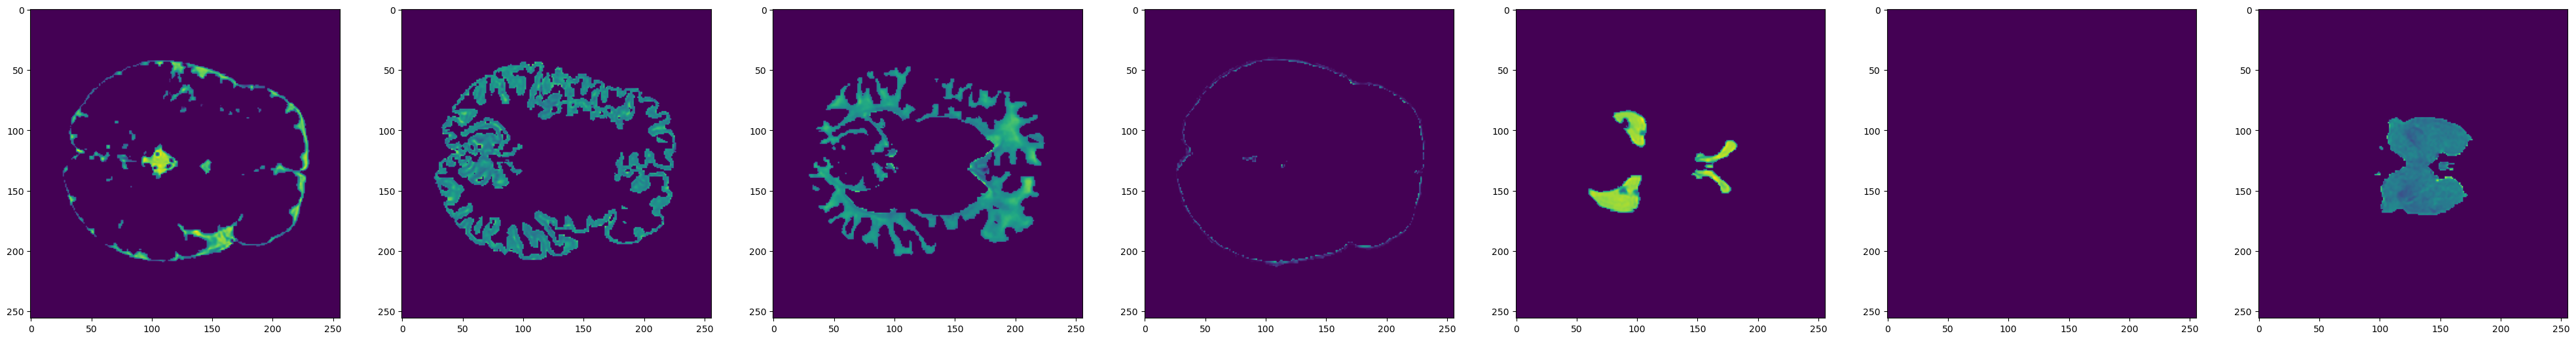

In [65]:
fig, ax = plt.subplots(1, 7, figsize=(50,20))
for i in range(0, 7):
    ax[i].imshow(res[i])

In [61]:
np.sum(res_np, axis=0).shape

(256, 256)

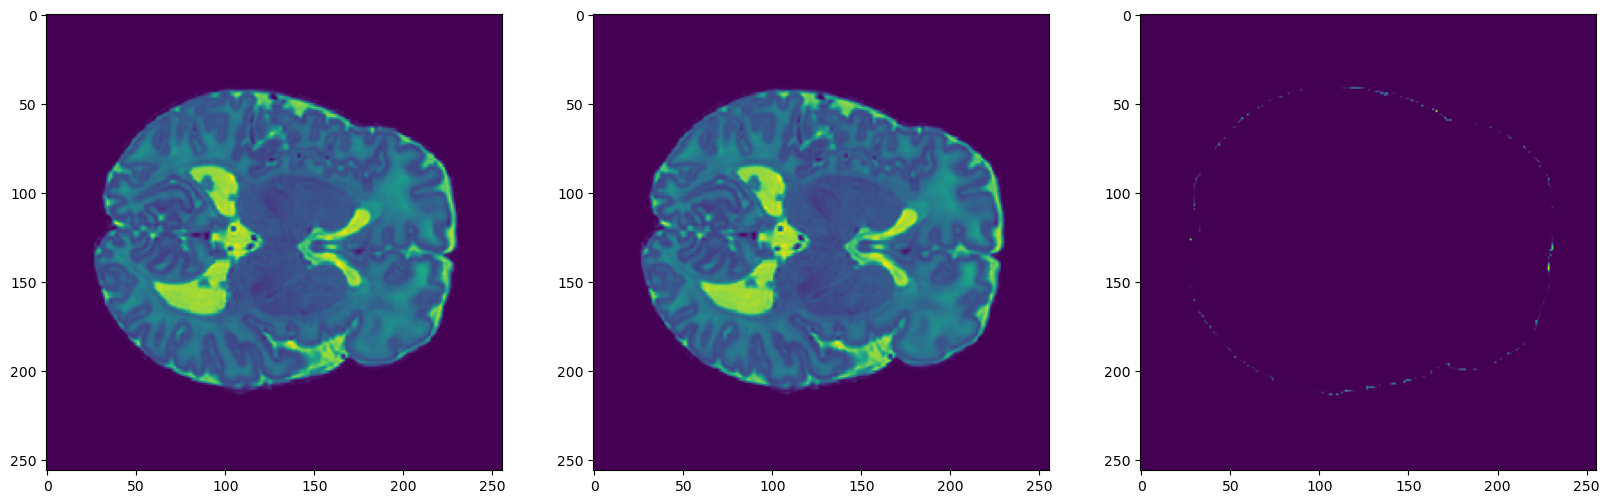

In [66]:
res_np = np.array(res)
fig, ax = plt.subplots(1, 3, figsize=(20,20))
ax[0].imshow(t2_slc)
ax[1].imshow(np.sum(res_np, axis=0))
ax[2].imshow(t2_slc - np.sum(res_np, axis=0))

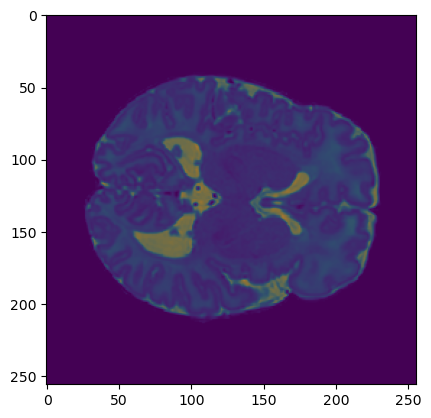

In [44]:
t2_slc = t2_processed.numpy()[:,:,128]
# seg_slc = seg_transform.numpy()[:,:,128]
# seg_slc[seg_slc != 0] = -1
plt.imshow(t2_slc)
plt.imshow(seg_slc, alpha=0.5)

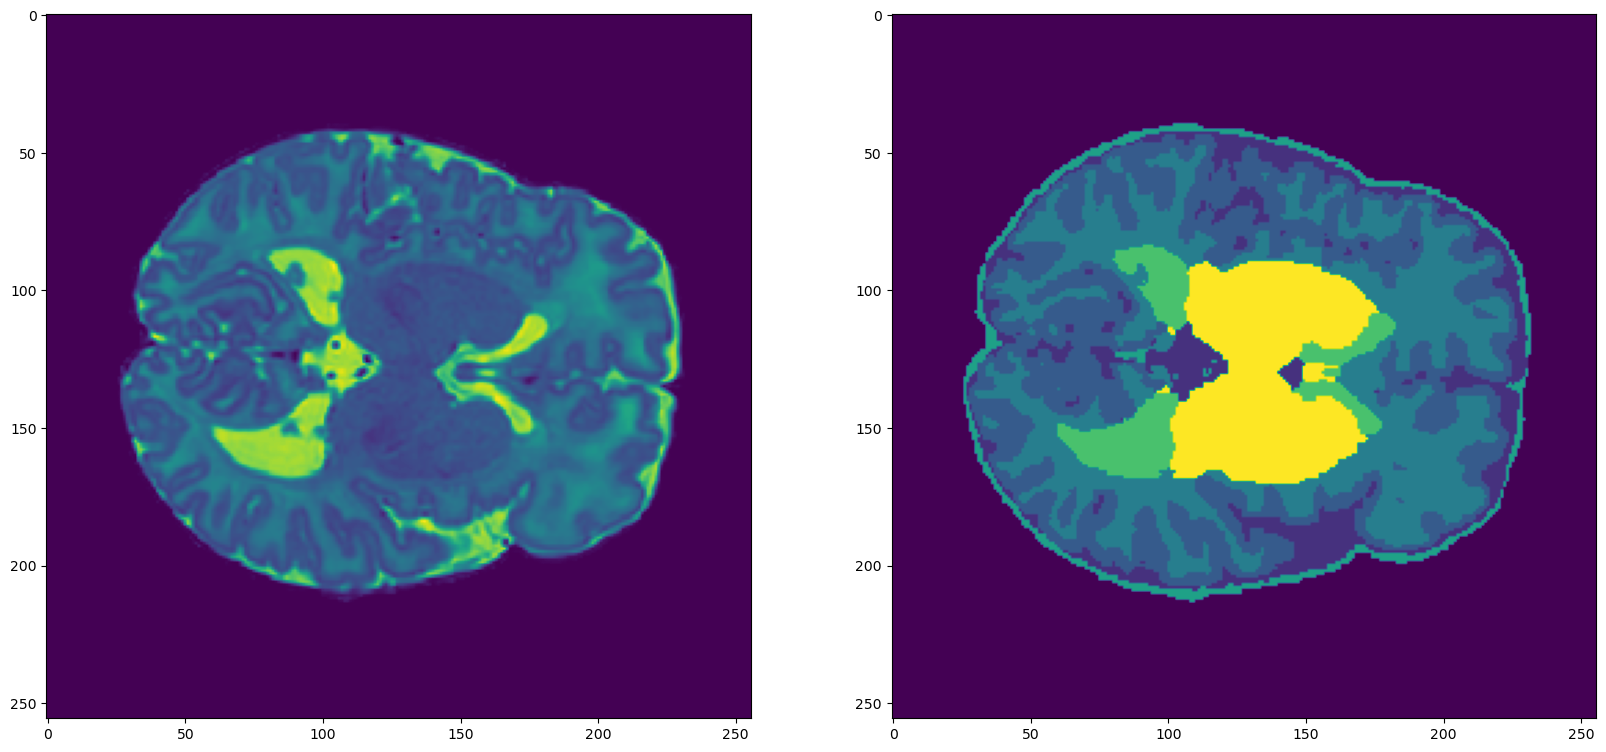

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(t2_processed.numpy()[:,:,128])
ax[1].imshow(seg_transform.numpy()[:,:,128])

### END ASIDE

In [7]:
%%time

level = 5
session_list = [x.split("_T")[0] for x in os.listdir(os.path.join(og_volumes, f"l{level}"))]
unique_sessions = list(np.unique(session_list))
dims = (256, 256, 256)

for session in unique_sessions:
    t1_path = os.path.join(og_volumes, f"l{level}", f"{session}_T1w.nii.gz")
    t2_path = os.path.join(og_volumes, f"l{level}", f"{session}_T2w.nii.gz")
    seg_path = os.path.join(og_segments, f"l{level}", f"{session}_9em_seg.nii.gz")
    mask_path = os.path.join(og_segments, f"l{level}", f"{session}_bet_mask.nii.gz")

    t1 = ants.image_read(t1_path)
    t2 = ants.image_read(t2_path)
    # seg = ants.image_read(seg_path)
    mask = ants.image_read(mask_path)
    
    t1_processed = process_image(t1, mask, dims, processed_ref, uniform)
    t2_processed = process_image(t2, mask, dims, processed_ref, uniform)
    # seg_processed = process_image(seg, mask, dims, processed_ref, uniform, skip_norm=True).numpy()
    
    t1_processed_path = os.path.join(processed_volumes, f"l{level}", f"{session}_T1w.npy")
    np.save(t1_processed_path, t1_processed)
    
    t2_processed_path = os.path.join(processed_volumes, f"l{level}", f"{session}_T2w.npy")
    np.save(t2_processed_path, t2_processed)
    
    print(f"Finished processing {session}")
    # seg_processed_path = os.path.join(processed_segments, f"l{level}", f"{session}_seg.npy")
    # np.save(seg_processed_path, seg_processed)

CPU times: user 3.18 ms, sys: 278 µs, total: 3.45 ms
Wall time: 4 ms


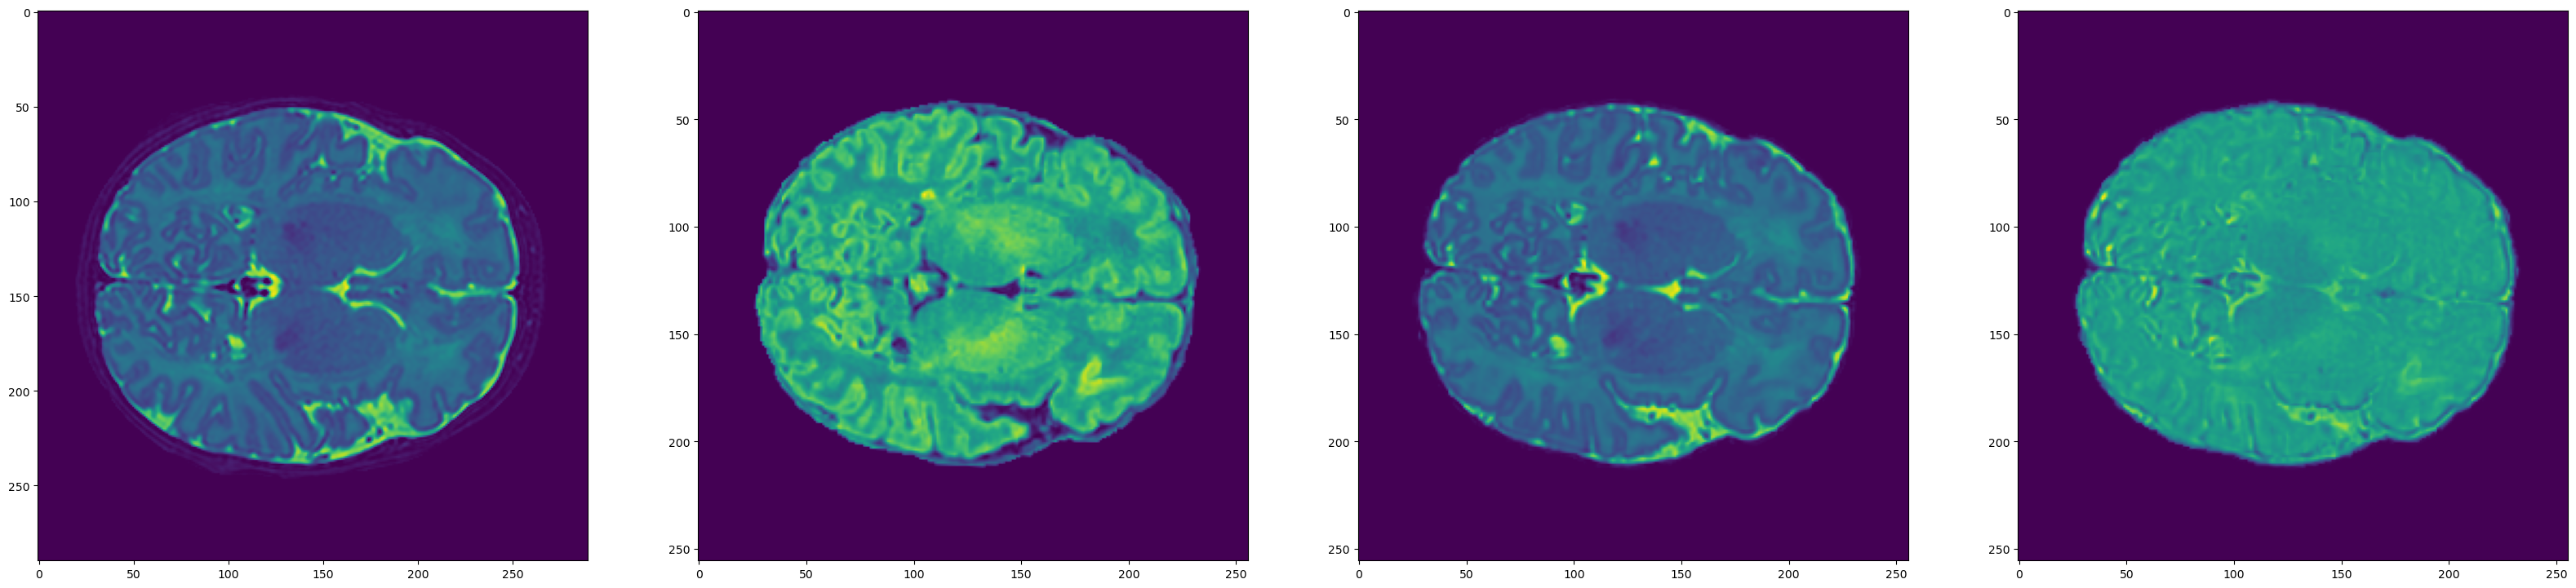

In [82]:
fig, ax = plt.subplots(1, 4, figsize=(40,20))

ax[0].imshow(t2.numpy()[:,:,101])
ax[1].imshow(t1_processed[:,:,128])
ax[2].imshow(t2_processed[:,:,128])
ax[3].imshow((t1_processed[:,:,128] + t2_processed[:,:,128]) / 2)

### Generate Registered Segmentation Masks

In [88]:
%%time

level = 1
session_list = [x.split("_T")[0] for x in os.listdir(os.path.join(og_volumes, f"l{level}"))]
unique_sessions = list(np.unique(session_list))
dims = (256, 256, 256)

for session in unique_sessions:
    t2_path = os.path.join(og_volumes, f"l{level}", f"{session}_T2w.nii.gz")
    seg_path = os.path.join(og_segments, f"l{level}", f"{session}_9em_seg.nii.gz")
    mask_path = os.path.join(og_segments, f"l{level}", f"{session}_bet_mask.nii.gz")

    t2 = ants.image_read(t2_path)
    seg = ants.image_read(seg_path)
    mask = ants.image_read(mask_path)
    
    t2_processed = ants.mask_image(t2, mask)
    t2_processed = ants.n3_bias_field_correction(t2_processed)
    t2_processed = ants.resample_image(t2_processed, dims, True, 1)
    t2_processed = ants.registration(fixed=processed_ref, moving=t2_processed, type_of_transform='AffineFast')
    fwd_transform = t2_processed['fwdtransforms']
    t2_processed = t2_processed['warpedmovout']
    
    seg_processed = ants.resample_image(seg, dims, True, 1)
    seg_processed = ants.apply_transforms(t2_processed, seg_processed, fwd_transform, interpolator="nearestNeighbor")

    seg_processed_path = os.path.join(processed_segments, f"l{level}", f"{session}_seg.npy")
    np.save(seg_processed_path, seg_processed.numpy())
    
    print(f"Finished processing {session}")

Finished processing sub-CC00062XX05_13801
Finished processing sub-CC00063AN06_15102
Finished processing sub-CC00067XX10_20200
Finished processing sub-CC00068XX11_20701
Finished processing sub-CC00071XX06_27000
Finished processing sub-CC00073XX08_27800
Finished processing sub-CC00074XX09_28000
Finished processing sub-CC00075XX10_28400
Finished processing sub-CC00079XX14_30000
Finished processing sub-CC00080XX07_30300
Finished processing sub-CC00082XX09_30700
Finished processing sub-CC00083XX10_30900
Finished processing sub-CC00084XX11_31201
Finished processing sub-CC00088XX15_31801
Finished processing sub-CC00089XX16_32101
Finished processing sub-CC00096XX15_33700
Finished processing sub-CC00099BN18_34201
Finished processing sub-CC00100XX01_35000
Finished processing sub-CC00101XX02_35001
Finished processing sub-CC00102XX03_35200
Finished processing sub-CC00104XX05_35800
Finished processing sub-CC00106XX07_36100
Finished processing sub-CC00107XX08_36300
Finished processing sub-CC00108XX0

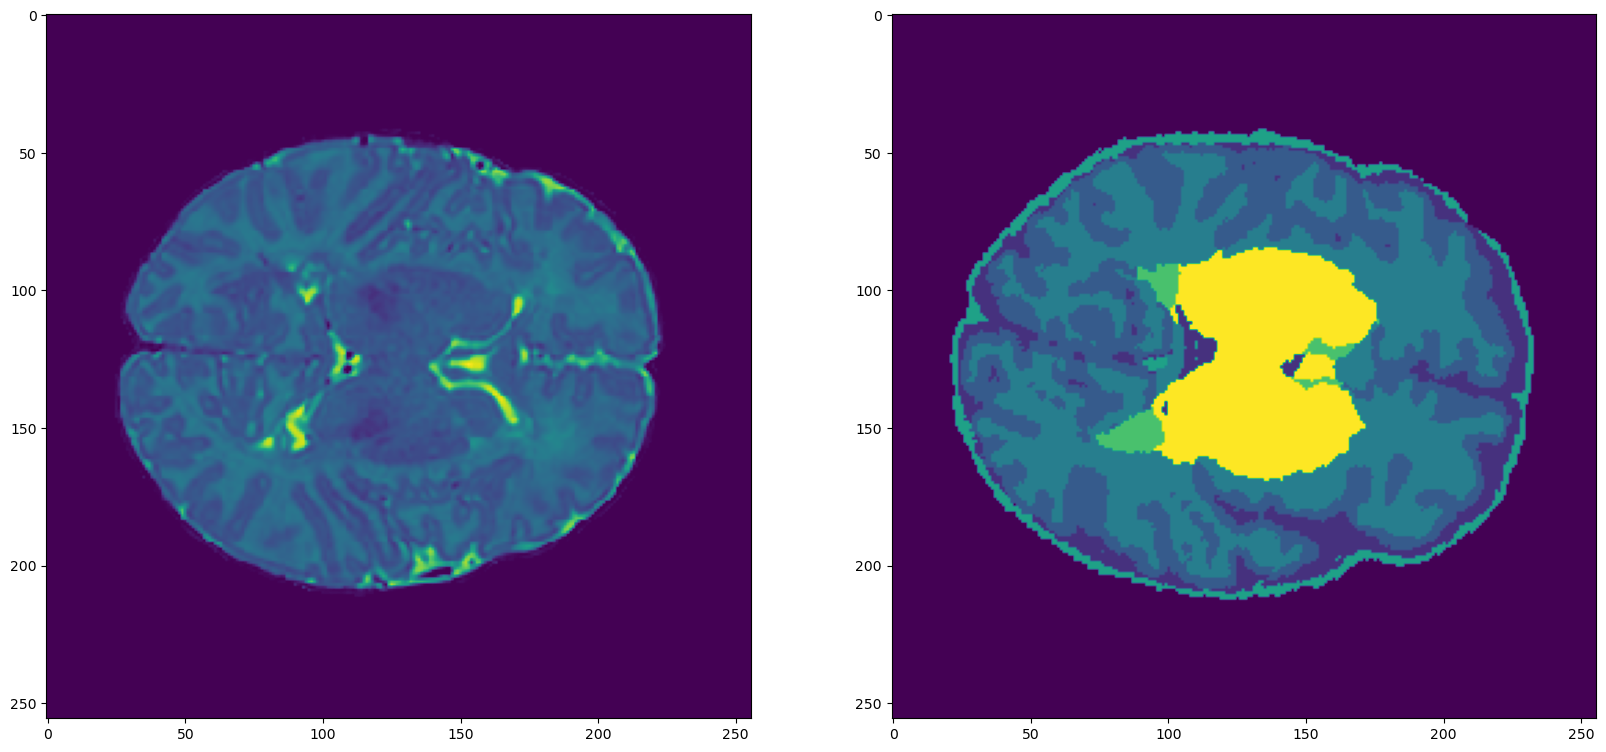

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(t2_processed.numpy()[:,:,128])
ax[1].imshow(seg_processed.numpy()[:,:,128])